In [1]:

import numpy as np # linear algebra
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as ts
import pandas as pd
from tensorflow.keras import layers
import numpy as np
from scipy.io import loadmat

from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os


In [2]:
labels = pd.read_csv("abcd_subjid_rfmricount_sc_age_sex_totalcog.csv",header=0)
print(labels.shape)

(9614, 6)


In [3]:
sex = labels.sex.values
age = labels.age.values
id = labels.id.values



In [4]:
def imageshow(imgarr,labelarr,amt):
  #https://stackoverflow.com/questions/41432568/show-multiple-image-in-matplotlib-from-numpy-array
  fig = plt.figure(figsize=(10,10))  # width, height in inches

  for i in range(amt):
    sub = fig.add_subplot(int(amt//10),10, i+1)
    sub.imshow(imgarr[i], interpolation='nearest')
    sub.set_title(labelarr[i])
    sub.axis("off")

In [39]:
mriarray = np.empty((9609,218,218))
count=0
for file in os.listdir("abcd_FC_schaefer200.17_aseg18_9609subj"):
        if(".mat" in file):
                mriarray[count] = loadmat("abcd_FC_schaefer200.17_aseg18_9609subj/"+file)['C']
                count+=1


In [40]:
mriarray = mriarray.astype('float32')
mriarray = np.expand_dims(mriarray,-1)


In [41]:
#remove null values
for i in range(9609):
   if(sex[i] != sex[i]):
        sex = np.delete(sex,i)
        mriarray = np.delete(mriarray,i,axis=0)


       

In [48]:
sextest = np.empty(len(mriarray)).astype('float32')
for i in range(len(mriarray)):
    sextest[i]=(ord(sex[i])-70)/7
sextest = keras.utils.to_categorical(sextest,2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


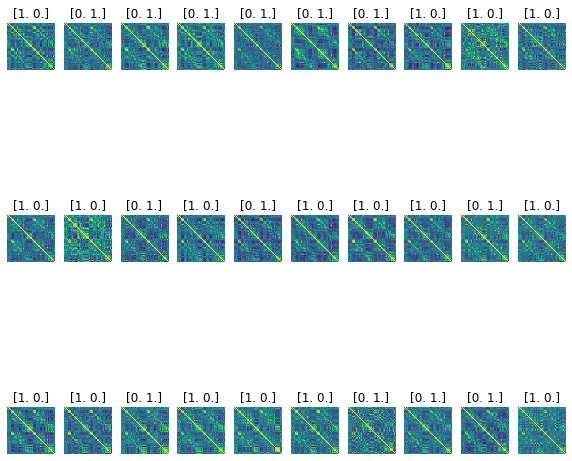

In [49]:
imageshow(mriarray,sextest,30)
#0=female, 1=male


In [58]:
model = keras.Sequential([
      keras.Input(shape=(218,218,1)),
      keras.layers.Rescaling(1./255),
      layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation="relu"),
      layers.MaxPool2D(),
      layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="relu",),
      layers.MaxPool2D(),
      layers.Flatten(),
    #  layers.Dense(50,activation="relu", name="layer1"),
        layers.Dense(25,activation="relu", name="layer2"),
        layers.Dropout(rate=0.5),
      layers.Dense(2,activation="softmax", name="layer3"),
  ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 218, 218, 1)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 218, 218, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 186624)           

In [34]:
#randomize data 
import random
x = random.randint(0,1000)
from sklearn.utils import shuffle
data_train, data_test, labels_train, labels_test = train_test_split(mrirray, cogtotal, test_size=0.20, random_state=x)
data_train = np.array(data_train)
data_train = shuffle(data_train,random_state=x)
labels_train=shuffle(labels_train,random_state=x)

print(data_train.shape)
print(x)
imageshow(data_train,labels_train,50)

NameError: name 'mrirray' is not defined

In [59]:
#model.fit(datagen.flow(mriarray,sextest,batch_size=32),steps_per_epoch=len(mriarray) / 32, epochs=44,verbose=1)
model.fit(mriarray,sextest,batch_size=128, epochs=5,validation_split=0.2)


Epoch 1/5
11/61 [====>.........................] - ETA: 3:25 - loss: 0.6938 - accuracy: 0.4886